# Imports

In [1]:
# Standard library imports
import os
import pickle
from collections import Counter
from pathlib import Path

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_rel, wilcoxon

# Scikit-learn imports
from sklearn.calibration import label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    auc,
    confusion_matrix,
    f1_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# LightGBM and XGBoost imports
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Setup

In [2]:
# Path files
INPUT_FOLDER = Path("../data")
OUTPUT_FOLDER = Path("../results")

ROC_CURVE_FOLDER = "roc_curve"
CONF_MATRIX_FOLDER = "conf_matrix"

# Ensure the output folders exist
(output_folder_structure := [
    OUTPUT_FOLDER,
    OUTPUT_FOLDER / "2_labels",
    OUTPUT_FOLDER / "3_labels",
    OUTPUT_FOLDER / "2_labels" / ROC_CURVE_FOLDER,
    OUTPUT_FOLDER / "2_labels" / CONF_MATRIX_FOLDER,
    OUTPUT_FOLDER / "3_labels" / ROC_CURVE_FOLDER,
    OUTPUT_FOLDER / "3_labels" / CONF_MATRIX_FOLDER
])

for folder in output_folder_structure:
    folder.mkdir(parents=True, exist_ok=True)

# Constants
n_jobs = 6
random_state = 42

# Input data
data = pd.read_csv(f"{INPUT_FOLDER}/preprocessed_fviii_dataset.csv")
y = data.pop("Label")
X = data
binary_columns = X.columns[:3]
numeric_columns = X.columns[3:]

# Define parameter grids
param_grids = {
    "AdaBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]},
    "Bagging": {"n_estimators": [50, 100, 200]},
    "DecisionTree": {"max_depth": [3, 5, 7]},
    "Dummy": {"strategy": ["stratified", "most_frequent", "prior", "uniform"]},
    "GaussianNB": {},
    "GradientBoosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0],
    },
    "KNeighbors": {"n_neighbors": [3, 5, 7]},
    "LightGBM": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]},
    "RandomForest": {"n_estimators": [100, 200, 300]},
    "XGBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]},
}

# Define classifiers
classifiers = {
    "AdaBoost": AdaBoostClassifier(random_state=random_state),
    "Bagging": BaggingClassifier(random_state=random_state),
    "DecisionTree": DecisionTreeClassifier(random_state=random_state),
    "Dummy": DummyClassifier(random_state=random_state),
    "GaussianNB": GaussianNB(),
    "GradientBoosting": GradientBoostingClassifier(random_state=random_state),
    "KNeighbors": KNeighborsClassifier(),
    "LightGBM": LGBMClassifier(random_state=random_state, nthread=1, verbose=-1),
    "RandomForest": RandomForestClassifier(random_state=random_state),
    "XGBoost": XGBClassifier(random_state=random_state, nthread=1),
}

# Define scalers
scalers = {
    "None": None,
    "Standard": StandardScaler(),
}

# Define labels variables
label_dict = {
    "3 Labels": y,
    "2 Labels": y.map(lambda lbl: 1 if lbl == 2 else 0),
}

# Outer cross-validation
outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)

# Inner cross-validation
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Functions (Run ML)

## Auxiliar

In [3]:
def get_label_names(n_labels):
    """
    Determine severity labels based on the number of labels provided.
    """
    # Check the number of labels and return the corresponding severity labels.
    if n_labels == 2:
        # For binary classification (e.g., non-severe vs. severe).
        return ["non-severe", "severe"]
    elif n_labels == 3:
        # For three classes (e.g., mild, moderate, severe).
        return ["mild", "moderate", "severe"]
    else:
        # If the number of labels does not match common scenarios, return a list of "Unknown".
        return ["Unknown"] * n_labels

In [4]:
def get_top_30_best_params(all_best_params):
    """
    Get the most common set of parameters from a list of best parameters.
    """
    # Convert each dictionary in the list to a frozenset of its items to count occurrences
    param_counter = Counter(map(frozenset, map(lambda d: d.items(), all_best_params)))
    
    # Find the most common frozenset of parameters and convert it back to a dictionary
    best_params = dict(param_counter.most_common(1)[0][0])
    
    return best_params

## Roc Curve

In [5]:
def create_plot_title(clf_name, scaler_name, label_name, class_name):
    """
    Create a formatted title for the ROC curve plot.
    """
    return f"ROC Curve: {clf_name}, {scaler_name}, {label_name} (Class: {class_name})"

def create_file_path(clf_name, scaler_name, label_name, class_name, n_labels):
    """
    Create a formatted file path for saving the ROC curve plot.
    """
    return (
        f"{OUTPUT_FOLDER}/{n_labels}_labels/{ROC_CURVE_FOLDER}/"
        f"ROCCurve_{clf_name}_{scaler_name}_{label_name}_Class_{class_name}.png"
    )

def plot_roc_curve(fpr, tpr, roc_auc, clf_name, scaler_name, label_name, n_labels, label_names, class_index):
    """
    Plot and save the ROC curve.
    """
    # Create the title and file path
    title = create_plot_title(clf_name, scaler_name, label_name, label_names[class_index])
    file_path = create_file_path(clf_name, scaler_name, label_name, label_names[class_index], n_labels)
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(file_path)
    plt.close()

def compute_and_plot_roc(all_true_labels, all_probabilities, clf_name, scaler_name, label_name, n_labels):
    """
    Compute ROC curve and AUC, then plot and save the ROC curve.
    """
    if n_labels == 2:
        # For binary classification
        fpr, tpr, _ = roc_curve(all_true_labels, all_probabilities[:, 1])
        roc_auc = auc(fpr, tpr)
        plot_roc_curve(
            fpr,
            tpr,
            roc_auc,
            clf_name,
            scaler_name,
            label_name,
            n_labels,
            get_label_names(n_labels),
            1,
        )
    else:
        # For multi-class classification
        all_true_labels_bin = label_binarize(all_true_labels, classes=np.unique(all_true_labels))
        for i, class_name in enumerate(np.unique(all_true_labels)):
            fpr, tpr, _ = roc_curve(all_true_labels_bin[:, i], all_probabilities[:, i])
            roc_auc = auc(fpr, tpr)
            plot_roc_curve(
                fpr,
                tpr,
                roc_auc,
                clf_name,
                scaler_name,
                label_name,
                n_labels,
                get_label_names(n_labels),
                i,
            )

## Confusion Matrix

In [6]:
def create_conf_matrix_title(clf_name, scaler_name, label_name):
    """
    Create a formatted title for the confusion matrix plot.
    """
    return f"Confusion Matrix: {clf_name}, {scaler_name}, {label_name}"

def create_conf_matrix_file_path(clf_name, scaler_name, label_name, n_labels):
    """
    Create a formatted file path for saving the confusion matrix plot.
    """
    return (
        f"{OUTPUT_FOLDER}/{n_labels}_labels/{CONF_MATRIX_FOLDER}/"
        f"ConfMatrix_{clf_name}_{scaler_name}_{label_name}.png"
    )

def plot_confusion_matrix(conf_matrix, clf_name, scaler_name, label_name, n_labels):
    """
    Plot and save the confusion matrix.
    """    
    # Create the title and file path
    title = create_conf_matrix_title(clf_name, scaler_name, label_name)
    file_path = create_conf_matrix_file_path(clf_name, scaler_name, label_name, n_labels)
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Plotting the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=get_label_names(n_labels))
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(title)
    plt.savefig(file_path)
    plt.close()

## Nested Cross Validation

In [7]:
def cross_val_predict_collect(grid_search, outer_cv, features, label):
    """
    Cross-Validation with Predictions Collection.

    Perform cross-validation, fit the model, and collect true labels, predictions, 
    and performance metrics.
    """
    # Initialize storage for results
    all_true_labels = np.array([])
    all_predictions = np.array([])
    all_probabilities = np.array([])
    all_best_params = []
    metrics = {
        "accuracy": [],
        "roc_auc_ovr": [],
        "f1_macro": [],
        "recall_macro": []
    }

    # Iterate over each fold in the outer cross-validation
    for train_index, test_index in outer_cv.split(features, label):
        # Split data into training and testing sets for this fold
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = label.iloc[train_index], label.iloc[test_index]

        # Fit the grid search on the training data
        grid_search.fit(X_train, y_train)
        best_estimator = grid_search.best_estimator_

        # Predict labels and probabilities on the testing data
        outer_pred = best_estimator.predict(X_test)
        outer_prob = best_estimator.predict_proba(X_test)

        # Collect the true labels
        all_true_labels = np.append(all_true_labels, y_test)

        # Collect the predictions
        all_predictions = np.append(all_predictions, outer_pred)

        # Collect the probabilities
        all_probabilities = (
            np.vstack([all_probabilities, outer_prob])
            if all_probabilities.size
            else outer_prob
        )

        # Store the best parameters from the grid search
        all_best_params.append(grid_search.best_params_)

        # Calculate and store performance metrics
        accuracy = best_estimator.score(X_test, y_test)
        metrics["accuracy"].append(accuracy)
        
        # Differentiate between binary and non-binary cases for ROC AUC calculation
        unique_labels = np.unique(y_test)
        if len(unique_labels) == 2:
            # Binary classification case
            roc_auc = roc_auc_score(y_test, outer_prob[:, 1])
        else:
            # Multi-class classification case
            roc_auc = roc_auc_score(y_test, outer_prob, multi_class="ovr")
        metrics["roc_auc_ovr"].append(roc_auc)

        f1 = f1_score(y_test, outer_pred, average="macro")
        metrics["f1_macro"].append(f1)

        recall = recall_score(y_test, outer_pred, average="macro")
        metrics["recall_macro"].append(recall)

    # Return collected labels, predictions, probabilities, best parameters, and metrics
    return all_true_labels, all_predictions, all_probabilities, all_best_params, metrics

## ML Pipeline

In [8]:
def process_pipeline(clf_name, clf, scaler_name, scaler, labels_name, labels, iteration, max_iteration):
    """
    Process the machine learning pipeline for a given classifier, scaler, and labels.
    """
    # Determine the number of unique labels
    n_labels = len(np.unique(labels))
    print(f"=== {iteration}/{max_iteration} - Processing labels: {labels_name}, Scaler: {scaler_name}, Classifier: {clf_name} ===")

    # Define the preprocessing pipeline
    if scaler is not None:
        preprocessor = ColumnTransformer([("numeric", scaler, numeric_columns)], remainder="passthrough")
    else:
        preprocessor = "passthrough"  # Pass through data if no scaler

    # Combine preprocessor and classifier into a single pipeline
    pipeline = Pipeline([("preprocessor", preprocessor), ("clf", clf)])

    # Get the parameter grid for the classifier and adapt it for the pipeline
    param_grid = param_grids[clf_name]
    param_grid = {f"clf__{k}": v for k, v in param_grid.items()}

    # Initialize GridSearchCV for nested cross-validation
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="accuracy",
        cv=inner_cv,
        refit=True,
        n_jobs=n_jobs,
        return_train_score=True,
    )

    # Perform cross-validation and collect predictions
    all_true_labels, all_predictions, all_probabilities, all_best_params, metrics = cross_val_predict_collect(
        grid_search, outer_cv, X, labels
    )

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)
    # Plot and save the confusion matrix
    plot_confusion_matrix(conf_matrix, clf_name, scaler_name, labels_name, n_labels)

    # Compute and plot ROC curve and AUC
    compute_and_plot_roc(all_true_labels, all_probabilities, clf_name, scaler_name, labels_name, n_labels)

    # Calculate mean and standard deviation for accuracy
    mean_accuracy = np.mean(metrics["accuracy"])
    std_accuracy = np.std(metrics["accuracy"])
    
    # Calculate mean for other metrics
    mean_roc_auc_ovr = np.mean(metrics["roc_auc_ovr"])
    mean_f1_macro = np.mean(metrics["f1_macro"])
    mean_recall_macro = np.mean(metrics["recall_macro"])

    # Get the top 30 best parameters
    best_params = get_top_30_best_params(all_best_params)
    best_params = {f"{k.replace('clf__', '')}": v for k, v in best_params.items()}

    # Store results in a dictionary
    result_dict = {
        "nLabels": n_labels,
        "Labels": get_label_names(n_labels),
        "Classifier": clf_name,
        "Scaler": scaler_name,
        "Std Accuracy": std_accuracy,
        "Mean Accuracy": mean_accuracy,
        "Mean Macro OVR ROC AUC": mean_roc_auc_ovr,
        "Mean Macro F1": mean_f1_macro,
        "Mean Macro Recall": mean_recall_macro,
        "Best Hyperparameters Values": best_params,
        "All Accuracies": metrics["accuracy"],
        "Confusion Matrix": conf_matrix,
        "All True Labels": all_true_labels,
        "All Predictions": all_predictions,
        "All Probabilities": all_probabilities,
    }

    return result_dict

# Run 

In [ ]:
# List to store ml pipeline results
results = []

# Calculate the total number of iterations
max_iterations = len(classifiers) * len(scalers) * len(label_dict)
iteration_count = 1

# Iterate over each combination of labels, scalers, and classifiers
for label_name, labels in label_dict.items():
    for scaler_name, scaler in scalers.items():
        for classifier_name, classifier in classifiers.items():
            # Process the pipeline and collect results
            result = process_pipeline(
                classifier_name,
                classifier,
                scaler_name,
                scaler,
                label_name,
                labels,
                iteration_count,
                max_iterations,
            )
            results.append(result)
            iteration_count += 1

# # Save the detailed results list for later use
# with open(os.path.join(OUTPUT_FOLDER, "detailed_results_list.pkl"), "wb") as f:
#     pickle.dump(results, f)

# Functions (Process Results)

In [10]:
# Function to create and process the results DataFrame
def create_and_process_results_df(results):
    # Create DataFrame from results list
    results_df = pd.DataFrame([
        {
            "nLabels": res["nLabels"],
            "Labels": res["Labels"],
            "Classifier": res["Classifier"],
            "Scaler": res["Scaler"],
            "Std Accuracy": res["Std Accuracy"],
            "Mean Accuracy": res["Mean Accuracy"],
            "Mean Macro OVR ROC AUC": res["Mean Macro OVR ROC AUC"],
            "Mean Macro F1": res["Mean Macro F1"],
            "Mean Macro Recall": res["Mean Macro Recall"],
            "Best Hyperparameters Values": res["Best Hyperparameters Values"],
            "All Accuracies": res["All Accuracies"],
        }
        for res in results
    ])

    # Sort by metrics
    sorted_df = results_df.sort_values(
        by=["Mean Accuracy", "Mean Macro OVR ROC AUC", "Mean Macro F1", "Mean Macro Recall"],
        ascending=False
    ).reset_index(drop=True)

    # Round the metrics
    metrics_to_round = ["Mean Accuracy", "Mean Macro OVR ROC AUC", "Mean Macro F1", "Mean Macro Recall"]
    sorted_df[metrics_to_round] = sorted_df[metrics_to_round].round(3)
    sorted_df["Std Accuracy"] = sorted_df["Std Accuracy"].round(2)

    return sorted_df

# Create the results DataFrame
results_df = create_and_process_results_df(results)

# Display the sorted and rounded DataFrame
display(results_df)

,nLabels,Labels,Classifier,Scaler,Std Accuracy,Mean Accuracy,Mean Macro OVR ROC AUC,Mean Macro F1,Mean Macro Recall,Best Hyperparameters Values,All Accuracies
0,2,"[non-severe, severe]",RandomForest,Standard,0.06,0.784,0.808,0.752,0.744,{'n_estimators': 200},"[0.8809523809523809, 0.8333333333333334, 0.833..."
1,2,"[non-severe, severe]",RandomForest,None,0.06,0.781,0.804,0.751,0.743,{'n_estimators': 300},"[0.8571428571428571, 0.8333333333333334, 0.785..."
2,2,"[non-severe, severe]",XGBoost,None,0.05,0.772,0.776,0.742,0.736,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8095238095238095, 0.8333333333333334, 0.761..."
3,2,"[non-severe, severe]",XGBoost,Standard,0.05,0.771,0.776,0.741,0.735,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8095238095238095, 0.8333333333333334, 0.761..."
4,2,"[non-severe, severe]",Bagging,None,0.07,0.760,0.787,0.732,0.727,{'n_estimators': 100},"[0.8809523809523809, 0.8333333333333334, 0.809..."
5,2,"[non-severe, severe]",LightGBM,Standard,0.06,0.758,0.783,0.726,0.722,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8333333333333334, 0.7619047619047619, 0.785..."
6,2,"[non-severe, severe]",Bagging,Standard,0.07,0.756,0.790,0.728,0.724,{'n_estimators': 200},"[0.8333333333333334, 0.7857142857142857, 0.809..."
7,2,"[non-severe, severe]",GradientBoosting,None,0.06,0.751,0.774,0.712,0.705,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8095238095238095, 0.8095238095238095, 0.809..."
8,2,"[non-severe, severe]",GradientBoosting,Standard,0.06,0.750,0.771,0.714,0.708,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8095238095238095, 0.8095238095238095, 0.809..."
9,2,"[non-severe, severe]",LightGBM,None,0.07,0.744,0.776,0.706,0.703,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8333333333333334, 0.8095238095238095, 0.857..."


## Boxplots

In [11]:
def boxplots(my_df, n_labels, init_name, xsize=10, ysize=3):
    """
    Create and save boxplots for accuracy scores.
    """
    # Create output directory
    output_dir = Path(OUTPUT_FOLDER) / f"{n_labels}_labels" / "boxplots"
    output_dir.mkdir(parents=True, exist_ok=True)

    # Copy the DataFrame to avoid modifying the original
    df = my_df.copy()
    df = df.rename(columns={"All Accuracies": "Accuracy of 30 Folds"})

    # Create a new column for boxplot labels
    df["Boxplot labels"] = df["Classifier"] + " (" + df["Scaler"] + ")"

    # Remove duplicates based on classifier to ensure unique labels
    df = df.drop_duplicates("Classifier")

    # Expand the 'Accuracy of 30 Folds' column to multiple rows
    df = df.explode("Accuracy of 30 Folds")

    # Create the boxplot
    plt.figure(figsize=(xsize, ysize))
    sns.boxplot(data=df, y="Boxplot labels", x="Accuracy of 30 Folds", orient="h")

    # Optionally set x-axis limits based on number of labels
    # if n_labels == 2:
    #     plt.xlim(0.50, 1.00)
    # if n_labels == 3:
    #     plt.xlim(0.30, 1.00)

    # Set plot title based on number of labels
    label_names = "2 Labels: non-severe, severe" if n_labels == 2 else "3 Labels: mild, moderate, severe"
    plt.title(label_names)
    plt.ylabel("")
    plt.tight_layout()

    # Save the plot to the specified output path
    output_path = output_dir / f"{init_name}_{n_labels}_labels_accuracy_boxplots.png"
    plt.savefig(output_path, dpi=300)
    plt.show()

## Format for Latex

In [12]:
# Function to format DataFrame for export
def format_to_export(my_df):
    df = my_df.copy()
    df = df.drop(columns="All Accuracies")
    df = df.drop(columns="Labels")
    df = df.drop(columns="nLabels")
    
    df["Std Accuracy"] = df["Std Accuracy"].map("{:.2f}".format)
    df["Mean Accuracy"] = df["Mean Accuracy"].map("{:.3f}".format)
    df["Mean Macro OVR ROC AUC"] = df["Mean Macro OVR ROC AUC"].map("{:.3f}".format)
    df["Mean Macro F1"] = df["Mean Macro F1"].map("{:.3f}".format)
    df["Mean Macro Recall"] = df["Mean Macro Recall"].map("{:.3f}".format)

    # Format parameters for LaTeX compatibility
    def format_params(params):
        str_params = str(params)
        str_params = str_params.replace("_", "\\_")
        str_params = str_params.replace("'", "")
        str_params = str_params.replace(",", ", ")
        return "{" + str_params + "}"
    
    df["Best Hyperparameters Values"] = df["Best Hyperparameters Values"].apply(format_params)

    display(df)
    return df

## Process Results and Export

In [13]:
# Ensure the output folder exists
def create_output_folder(output_folder):
    """Create Output Folder"""
    os.makedirs(output_folder, exist_ok=True)

# Analyze the effect of scaling
def analyze_scaler_effect(results_df):
    """Analyze Scaler Effect"""
    # Group by scaler and calculate metrics mean and std
    grouped_df = (results_df.groupby("Scaler")
                  .agg({"Mean Accuracy": ["mean", "std"],
                        "Mean Macro OVR ROC AUC": ["mean", "std"],
                        "Mean Macro F1": ["mean", "std"],
                        "Mean Macro Recall": ["mean", "std"]})
                  .reset_index())

    # Format mean and std
    def format_column(col, col_name):
        if col_name[1] == 'mean':
            return col.apply(lambda x: f"{x:.3f}")
        elif col_name[1] == 'std':
            return col.apply(lambda x: f"{x:.2f}")
        return col

    # Apply format to export
    formatted_df = grouped_df.copy()
    for col in formatted_df.columns:
        formatted_df[col] = format_column(formatted_df[col], col)

    return formatted_df


# Get the top 3 models based on the results
def get_top3_models(results_df):
    """Get Top 3 Models"""
    return results_df.drop_duplicates("Classifier").head(3)

# Perform statistical tests on the top 3 models
def perform_statistical_tests(top3_models, results_df):
    """Perform Statistical Tests"""
    classifiers_abbr = {
        "Dummy": "Dmy", "GaussianNB": "GNB", "KNeighbors": "KNN", "DecisionTree": "DTree",
        "RandomForest": "RF", "AdaBoost": "AdaB", "Bagging": "Bag", "GradientBoosting": "GB",
        "XGBoost": "XGB", "LightGBM": "LGBM"
    }
    
    top3_model_names = top3_models["Classifier"].values
    top3_model_accuracies = [
        results_df[results_df["Classifier"] == name]["All Accuracies"].values[0]
        for name in top3_model_names
    ]
    
    n = len(top3_model_names)
    stat_test_matrix = np.empty((n, n), dtype=object)
    
    for i in range(n):
        for j in range(n):
            if i == j:
                stat_test_matrix[i, j] = classifiers_abbr[top3_model_names[i]]
            elif i < j:
                _, t_pvalue = ttest_rel(top3_model_accuracies[i], top3_model_accuracies[j])
                t_pvalue = f"\\textbf{{{t_pvalue:.2f}}}" if t_pvalue <= 0.05 else f"{t_pvalue:.2f}"
                stat_test_matrix[i, j] = t_pvalue
            else:
                _, w_pvalue = wilcoxon(top3_model_accuracies[i], top3_model_accuracies[j])
                w_pvalue = f"\\textbf{{{w_pvalue:.2f}}}" if w_pvalue <= 0.05 else f"{w_pvalue:.2f}"
                stat_test_matrix[i, j] = w_pvalue
                
    return pd.DataFrame(stat_test_matrix, index=top3_model_names, columns=top3_model_names)

# Format and export results
def export_results(results_df, top3_models, results_scaler_effect, top3_models_stats_test, output_folder, n_labels):
    """Export Results"""
    results_df_formatted = format_to_export(results_df)
    results_df_formatted.to_csv(os.path.join(output_folder, f"all_models_{n_labels}_labels.csv"), index=False)
    results_df_formatted.to_latex(os.path.join(output_folder, f"all_models_{n_labels}_labels.tex"), index=False)
    
    top3_models_formatted = format_to_export(top3_models)
    top3_models_formatted.to_csv(os.path.join(output_folder, f"top3_models_{n_labels}_labels.csv"), index=False)
    top3_models_formatted.to_latex(os.path.join(output_folder, f"top3_models_{n_labels}_labels.tex"), index=False)
    
    top3_models_stats_test.to_csv(os.path.join(output_folder, f"top3_models_stats_test_{n_labels}_labels.csv"), index=False)
    top3_models_stats_test.to_latex(os.path.join(output_folder, f"top3_models_stats_test_{n_labels}_labels.tex"), index=False)
    
    results_scaler_effect.to_csv(os.path.join(output_folder, f"all_models_scaler_effect_{n_labels}_labels.csv"), index=False)
    results_scaler_effect.to_latex(os.path.join(output_folder, f"all_models_scaler_effect_{n_labels}_labels.tex"), index=False)

# Main processing function
def process_results(results_df, output_folder, n_labels):
    """Process Results"""
    create_output_folder(output_folder)
    
    print("Results DataFrame:")
    display(results_df)
    
    # Create boxplots for all models
    boxplots(results_df, n_labels, init_name="all_models")
    
    # Analyze the effect of scaling
    results_scaler_effect = analyze_scaler_effect(results_df)
    
    print("\nScaler Effect Analysis:")
    display(results_scaler_effect)
    
    # Get the top 3 models
    top3_models = get_top3_models(results_df)
    
    print("\nTop 3 Models:")
    display(top3_models)
    
    # Create boxplots for the top 3 models
    boxplots(top3_models, n_labels, init_name="top3_models")
    
    # Perform statistical tests on the top 3 models
    top3_models_stats_test = perform_statistical_tests(top3_models, results_df)
    top3_models_stats_test.columns = top3_models_stats_test.index
    
    print("\nStatistical Test Matrix:")
    display(top3_models_stats_test)
    
    print("\nBest Model:")
    display(top3_models.head(1))
    
    # Export the results
    export_results(results_df, top3_models, results_scaler_effect, top3_models_stats_test, output_folder, n_labels)

# Function to process and save results for a specific number of labels
def process_and_save_results(results_df, n_labels):
    """Process and Save Results for Specified Labels"""
    results_df_filtered = results_df[results_df["nLabels"] == n_labels]
    process_results(
        results_df_filtered,
        os.path.join(OUTPUT_FOLDER, f"{n_labels}_labels/tables"),
        n_labels=n_labels,
    )

# Process 2 Labels

Results DataFrame:


,nLabels,Labels,Classifier,Scaler,Std Accuracy,Mean Accuracy,Mean Macro OVR ROC AUC,Mean Macro F1,Mean Macro Recall,Best Hyperparameters Values,All Accuracies
0,2,"[non-severe, severe]",RandomForest,Standard,0.06,0.784,0.808,0.752,0.744,{'n_estimators': 200},"[0.8809523809523809, 0.8333333333333334, 0.833..."
1,2,"[non-severe, severe]",RandomForest,None,0.06,0.781,0.804,0.751,0.743,{'n_estimators': 300},"[0.8571428571428571, 0.8333333333333334, 0.785..."
2,2,"[non-severe, severe]",XGBoost,None,0.05,0.772,0.776,0.742,0.736,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8095238095238095, 0.8333333333333334, 0.761..."
3,2,"[non-severe, severe]",XGBoost,Standard,0.05,0.771,0.776,0.741,0.735,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8095238095238095, 0.8333333333333334, 0.761..."
4,2,"[non-severe, severe]",Bagging,None,0.07,0.760,0.787,0.732,0.727,{'n_estimators': 100},"[0.8809523809523809, 0.8333333333333334, 0.809..."
5,2,"[non-severe, severe]",LightGBM,Standard,0.06,0.758,0.783,0.726,0.722,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8333333333333334, 0.7619047619047619, 0.785..."
6,2,"[non-severe, severe]",Bagging,Standard,0.07,0.756,0.790,0.728,0.724,{'n_estimators': 200},"[0.8333333333333334, 0.7857142857142857, 0.809..."
7,2,"[non-severe, severe]",GradientBoosting,None,0.06,0.751,0.774,0.712,0.705,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8095238095238095, 0.8095238095238095, 0.809..."
8,2,"[non-severe, severe]",GradientBoosting,Standard,0.06,0.750,0.771,0.714,0.708,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8095238095238095, 0.8095238095238095, 0.809..."
9,2,"[non-severe, severe]",LightGBM,None,0.07,0.744,0.776,0.706,0.703,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8333333333333334, 0.8095238095238095, 0.857..."


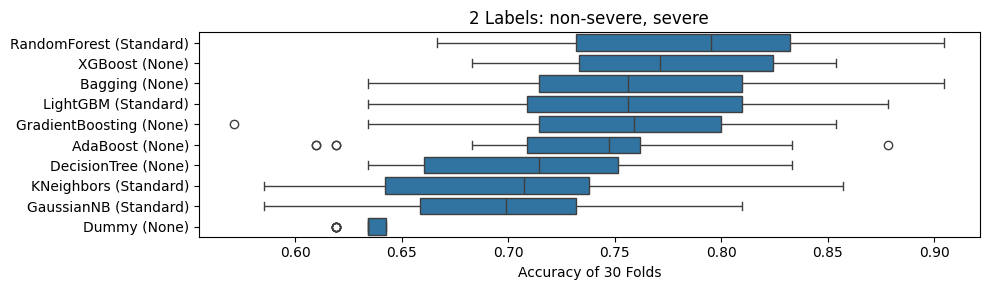


Scaler Effect Analysis:


Scaler Mean Accuracy       Mean Macro OVR ROC AUC       Mean Macro F1  \
                     mean   std                   mean   std          mean   
0      None         0.726  0.05                  0.729  0.09         0.668   
1  Standard         0.729  0.05                  0.732  0.09         0.671   

        Mean Macro Recall        
    std              mean   std  
0  0.11             0.676  0.07  
1  0.11             0.678  0.07


Top 3 Models:


,nLabels,Labels,Classifier,Scaler,Std Accuracy,Mean Accuracy,Mean Macro OVR ROC AUC,Mean Macro F1,Mean Macro Recall,Best Hyperparameters Values,All Accuracies
0,2,"[non-severe, severe]",RandomForest,Standard,0.06,0.784,0.808,0.752,0.744,{'n_estimators': 200},"[0.8809523809523809, 0.8333333333333334, 0.833..."
2,2,"[non-severe, severe]",XGBoost,None,0.05,0.772,0.776,0.742,0.736,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.8095238095238095, 0.8333333333333334, 0.761..."
4,2,"[non-severe, severe]",Bagging,None,0.07,0.760,0.787,0.732,0.727,{'n_estimators': 100},"[0.8809523809523809, 0.8333333333333334, 0.809..."


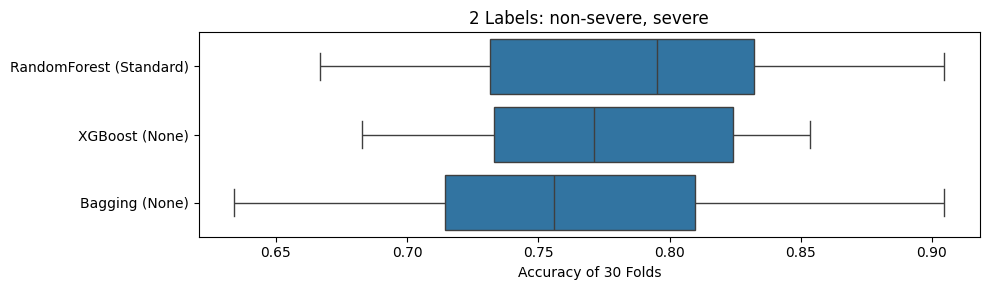


Statistical Test Matrix:


,RandomForest,XGBoost,Bagging
RandomForest,RF,0.19,\textbf{0.01}
XGBoost,0.30,XGB,0.25
Bagging,\textbf{0.01},0.39,Bag



Best Model:


,nLabels,Labels,Classifier,Scaler,Std Accuracy,Mean Accuracy,Mean Macro OVR ROC AUC,Mean Macro F1,Mean Macro Recall,Best Hyperparameters Values,All Accuracies
0,2,"[non-severe, severe]",RandomForest,Standard,0.06,0.784,0.808,0.752,0.744,{'n_estimators': 200},"[0.8809523809523809, 0.8333333333333334, 0.833..."


,Classifier,Scaler,Std Accuracy,Mean Accuracy,Mean Macro OVR ROC AUC,Mean Macro F1,Mean Macro Recall,Best Hyperparameters Values
0,RandomForest,Standard,0.06,0.784,0.808,0.752,0.744,{{n\_estimators: 200}}
1,RandomForest,None,0.06,0.781,0.804,0.751,0.743,{{n\_estimators: 300}}
2,XGBoost,None,0.05,0.772,0.776,0.742,0.736,"{{learning\_rate: 0.01, n\_estimators: 200}}"
3,XGBoost,Standard,0.05,0.771,0.776,0.741,0.735,"{{learning\_rate: 0.01, n\_estimators: 200}}"
4,Bagging,None,0.07,0.760,0.787,0.732,0.727,{{n\_estimators: 100}}
5,LightGBM,Standard,0.06,0.758,0.783,0.726,0.722,"{{learning\_rate: 0.01, n\_estimators: 200}}"
6,Bagging,Standard,0.07,0.756,0.790,0.728,0.724,{{n\_estimators: 200}}
7,GradientBoosting,None,0.06,0.751,0.774,0.712,0.705,"{{learning\_rate: 0.01, n\_estimators: 200}}"
8,GradientBoosting,Standard,0.06,0.750,0.771,0.714,0.708,"{{learning\_rate: 0.01, n\_estimators: 200}}"
9,LightGBM,None,0.07,0.744,0.776,0.706,0.703,"{{learning\_rate: 0.01, n\_estimators: 200}}"


,Classifier,Scaler,Std Accuracy,Mean Accuracy,Mean Macro OVR ROC AUC,Mean Macro F1,Mean Macro Recall,Best Hyperparameters Values
0,RandomForest,Standard,0.06,0.784,0.808,0.752,0.744,{{n\_estimators: 200}}
2,XGBoost,None,0.05,0.772,0.776,0.742,0.736,"{{learning\_rate: 0.01, n\_estimators: 200}}"
4,Bagging,None,0.07,0.760,0.787,0.732,0.727,{{n\_estimators: 100}}


In [14]:
# Process and save results for 2 Labels
process_and_save_results(results_df, 2)

# Process 3 Labels

Results DataFrame:


,nLabels,Labels,Classifier,Scaler,Std Accuracy,Mean Accuracy,Mean Macro OVR ROC AUC,Mean Macro F1,Mean Macro Recall,Best Hyperparameters Values,All Accuracies
18,3,"[mild, moderate, severe]",RandomForest,Standard,0.06,0.655,0.744,0.548,0.555,{'n_estimators': 200},"[0.7380952380952381, 0.6190476190476191, 0.642..."
19,3,"[mild, moderate, severe]",RandomForest,None,0.07,0.650,0.749,0.542,0.551,{'n_estimators': 200},"[0.6904761904761905, 0.6190476190476191, 0.619..."
20,3,"[mild, moderate, severe]",XGBoost,None,0.08,0.639,0.723,0.554,0.556,"{'learning_rate': 1.0, 'n_estimators': 200}","[0.6190476190476191, 0.6904761904761905, 0.595..."
21,3,"[mild, moderate, severe]",GradientBoosting,Standard,0.07,0.637,0.707,0.522,0.533,"{'n_estimators': 50, 'learning_rate': 0.1}","[0.7380952380952381, 0.6904761904761905, 0.571..."
22,3,"[mild, moderate, severe]",XGBoost,Standard,0.08,0.637,0.722,0.555,0.555,"{'n_estimators': 50, 'learning_rate': 0.1}","[0.6190476190476191, 0.6904761904761905, 0.595..."
25,3,"[mild, moderate, severe]",Bagging,None,0.08,0.633,0.734,0.528,0.538,{'n_estimators': 200},"[0.7142857142857143, 0.6428571428571429, 0.619..."
26,3,"[mild, moderate, severe]",Bagging,Standard,0.07,0.633,0.734,0.527,0.536,{'n_estimators': 200},"[0.7142857142857143, 0.6428571428571429, 0.619..."
27,3,"[mild, moderate, severe]",LightGBM,Standard,0.07,0.623,0.712,0.507,0.521,"{'n_estimators': 100, 'learning_rate': 0.01}","[0.6666666666666666, 0.6428571428571429, 0.619..."
28,3,"[mild, moderate, severe]",LightGBM,None,0.07,0.622,0.705,0.511,0.522,"{'learning_rate': 0.01, 'n_estimators': 200}","[0.6904761904761905, 0.6428571428571429, 0.595..."
29,3,"[mild, moderate, severe]",GradientBoosting,None,0.08,0.616,0.711,0.504,0.515,"{'n_estimators': 50, 'learning_rate': 0.1}","[0.7380952380952381, 0.6904761904761905, 0.5, ..."


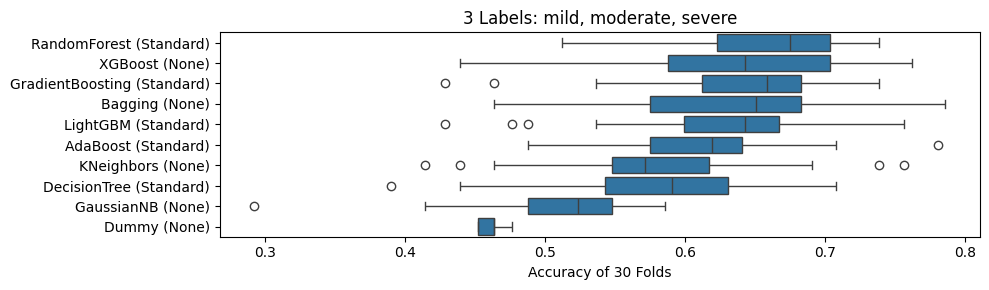


Scaler Effect Analysis:


Scaler Mean Accuracy       Mean Macro OVR ROC AUC       Mean Macro F1  \
                     mean   std                   mean   std          mean   
0      None         0.590  0.06                  0.677  0.07         0.462   
1  Standard         0.586  0.07                  0.673  0.07         0.454   

        Mean Macro Recall        
    std              mean   std  
0  0.10             0.488  0.07  
1  0.11             0.483  0.08


Top 3 Models:


,nLabels,Labels,Classifier,Scaler,Std Accuracy,Mean Accuracy,Mean Macro OVR ROC AUC,Mean Macro F1,Mean Macro Recall,Best Hyperparameters Values,All Accuracies
18,3,"[mild, moderate, severe]",RandomForest,Standard,0.06,0.655,0.744,0.548,0.555,{'n_estimators': 200},"[0.7380952380952381, 0.6190476190476191, 0.642..."
20,3,"[mild, moderate, severe]",XGBoost,None,0.08,0.639,0.723,0.554,0.556,"{'learning_rate': 1.0, 'n_estimators': 200}","[0.6190476190476191, 0.6904761904761905, 0.595..."
21,3,"[mild, moderate, severe]",GradientBoosting,Standard,0.07,0.637,0.707,0.522,0.533,"{'n_estimators': 50, 'learning_rate': 0.1}","[0.7380952380952381, 0.6904761904761905, 0.571..."


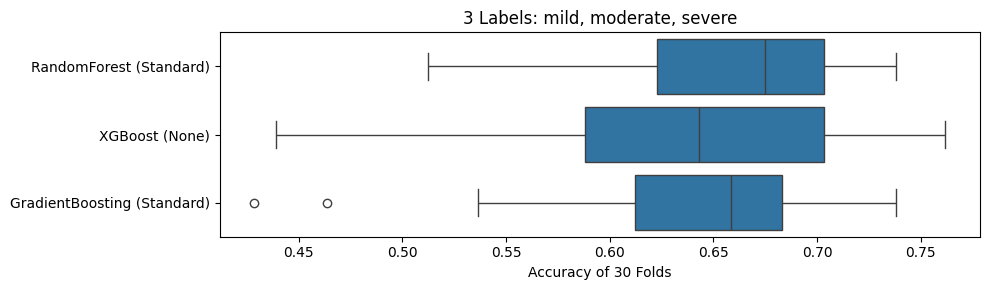


Statistical Test Matrix:


,RandomForest,XGBoost,GradientBoosting
RandomForest,RF,0.14,\textbf{0.03}
XGBoost,0.14,XGB,0.85
GradientBoosting,\textbf{0.04},0.89,GB



Best Model:


,nLabels,Labels,Classifier,Scaler,Std Accuracy,Mean Accuracy,Mean Macro OVR ROC AUC,Mean Macro F1,Mean Macro Recall,Best Hyperparameters Values,All Accuracies
18,3,"[mild, moderate, severe]",RandomForest,Standard,0.06,0.655,0.744,0.548,0.555,{'n_estimators': 200},"[0.7380952380952381, 0.6190476190476191, 0.642..."


,Classifier,Scaler,Std Accuracy,Mean Accuracy,Mean Macro OVR ROC AUC,Mean Macro F1,Mean Macro Recall,Best Hyperparameters Values
18,RandomForest,Standard,0.06,0.655,0.744,0.548,0.555,{{n\_estimators: 200}}
19,RandomForest,None,0.07,0.650,0.749,0.542,0.551,{{n\_estimators: 200}}
20,XGBoost,None,0.08,0.639,0.723,0.554,0.556,"{{learning\_rate: 1.0, n\_estimators: 200}}"
21,GradientBoosting,Standard,0.07,0.637,0.707,0.522,0.533,"{{n\_estimators: 50, learning\_rate: 0.1}}"
22,XGBoost,Standard,0.08,0.637,0.722,0.555,0.555,"{{n\_estimators: 50, learning\_rate: 0.1}}"
25,Bagging,None,0.08,0.633,0.734,0.528,0.538,{{n\_estimators: 200}}
26,Bagging,Standard,0.07,0.633,0.734,0.527,0.536,{{n\_estimators: 200}}
27,LightGBM,Standard,0.07,0.623,0.712,0.507,0.521,"{{n\_estimators: 100, learning\_rate: 0.01}}"
28,LightGBM,None,0.07,0.622,0.705,0.511,0.522,"{{learning\_rate: 0.01, n\_estimators: 200}}"
29,GradientBoosting,None,0.08,0.616,0.711,0.504,0.515,"{{n\_estimators: 50, learning\_rate: 0.1}}"


,Classifier,Scaler,Std Accuracy,Mean Accuracy,Mean Macro OVR ROC AUC,Mean Macro F1,Mean Macro Recall,Best Hyperparameters Values
18,RandomForest,Standard,0.06,0.655,0.744,0.548,0.555,{{n\_estimators: 200}}
20,XGBoost,None,0.08,0.639,0.723,0.554,0.556,"{{learning\_rate: 1.0, n\_estimators: 200}}"
21,GradientBoosting,Standard,0.07,0.637,0.707,0.522,0.533,"{{n\_estimators: 50, learning\_rate: 0.1}}"


In [15]:
# Process and save results for 3 Labels
process_and_save_results(results_df, 3)